Clase 15
===

Objetivos

* Estimación de los parámetros de una cinética de biomasa en un reactor por lotes.


Pero antes revisemos la resolución de problema de minimización de la clase 12
--------------    

La siguiente es la ecuación de una curva de títulación potenciometrica de una solución con metales pesados cuando al medio se agrega espirulina (biomasa de alga). Esta curva depende de la concentración de acido en el medio (medido como pH). Para modelar la relación entre el potencial y concentración de acido se puede usar la ecuación propuesta por [Chojnacka et al](https://www.sciencedirect.com/science/article/pii/S0045653504009026?casa_token=ApCxvb4D1bEAAAAA:yJXgN3HxFbHE4NpQF0yzuQgdTNwyObIuXsFBhVpkbtWuCbg7ogjpd4yLm-rVIYac7fPAq97b9yk):

<img src="https://raw.githubusercontent.com/mrivas/ModelamientoDeProcesosBiotecnologicos/master/clase12_equation.png" width="500">

La cual depende de 6 parametros: $K_{a1},K_{a2},K_{a3},a,b$ y $c$

Ejercicio:

Si los valores de pH y Xadd son:

```python
pH=[1.00000000e-02, 1.56333333e+00, 3.11666667e+00, 4.67000000e+00,
       6.22333333e+00, 7.77666667e+00, 9.33000000e+00, 1.08833333e+01,
       1.24366667e+01, 1.39900000e+01]
Xadd=[1.36349767, 0.8879697 , 0.85343802, 0.85242845, 0.85237857,
       0.85160556, 0.82511459, 0.44761206, 0.19211348, 0.18024773]
```

Ejercicio
------------

1. Haz el gráifco de pH (eje x) vs Xadd (eje y)
2. Estima el valor de los parámetros $K_{a1},K_{a2},K_{a3},a,b$ y $c$

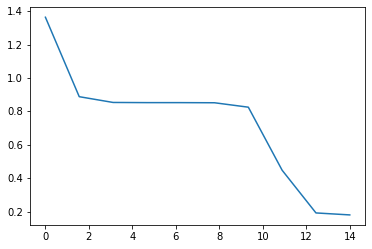

In [45]:
# Hacer el gráfico
pH=[1.00000000e-02, 1.56333333e+00, 3.11666667e+00, 4.67000000e+00,
       6.22333333e+00, 7.77666667e+00, 9.33000000e+00, 1.08833333e+01,
       1.24366667e+01, 1.39900000e+01]
Xadd=[1.36349767, 0.8879697 , 0.85343802, 0.85242845, 0.85237857,
       0.85160556, 0.82511459, 0.44761206, 0.19211348, 0.18024773]
plt.plot(pH,Xadd)

[-4.20243176e+02  6.55166892e+02  4.65703438e-01  7.72799304e-04
  2.50864567e-03 -9.99217202e-03]


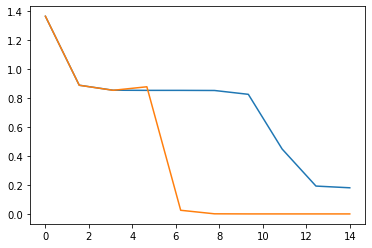

In [46]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy import optimize


pH=np.array([1.00000000e-02, 1.56333333e+00, 3.11666667e+00, 4.67000000e+00,
       6.22333333e+00, 7.77666667e+00, 9.33000000e+00, 1.08833333e+01,
       1.24366667e+01, 1.39900000e+01])
Xadd=np.array([1.36349767, 0.8879697 , 0.85343802, 0.85242845, 0.85237857,
       0.85160556, 0.82511459, 0.44761206, 0.19211348, 0.18024773])


def prediccion(params,pH):
        a, b, c, k1, k2, k3 = params
        cosa1= (a/(1+(np.power(10,-pH)/k2)+(np.power(10,-2*pH)/k1*k2)+(np.power(10,pH)*k3)))
        cosa2= (2*b/(1+(np.power(10,-pH)/k1)+np.power(10,pH)*k2+np.power(10,(2*pH))*k2*k3))
        cosa3= (3*c/(1+np.power(10,pH)*k1+np.power(10,2*pH)*k1*k2+np.power(10,3*pH)*k1*k2*k3))
        deriv = cosa1 + cosa2 + cosa3
        return (deriv)

def errorfinal(params):
    Xadd_predict = prediccion(params,pH)
    errorparc = np.power((Xadd - Xadd_predict),2)
    errortotal = np.sum(errorparc)
    return(errortotal)
params0= np.array([1,1,1,1,1,1])/2.0



solution=optimize.basinhopping(errorfinal,params0,stepsize=0.1)
print(solution.x)

plt.plot(pH,Xadd)
plt.plot(pH,prediccion(solution.x,pH))

[7.99807171e-01 8.10288719e-01 4.68246989e-01 7.38143685e-01
 7.95573657e-01 1.00000000e-12]


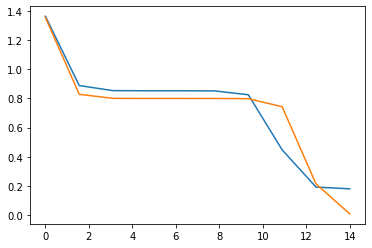

In [47]:
nParams=6
xmin=[1e-12]*nParams
xmax=[1.0]*nParams

bounds = [(low, high) for low, high in zip(xmin, xmax)]
minimizer_kwargs = dict(method="L-BFGS-B", bounds=bounds)

solution=optimize.basinhopping(errorfinal,params0,stepsize=0.1,minimizer_kwargs=minimizer_kwargs)
print(solution.x)

plt.plot(pH,Xadd)
plt.plot(pH,prediccion(solution.x,pH))

Estimación de parametros de un Reactor por lotes
-----------

Como recordatorio, consideremos lo visto en la clase 13. El siguiente sistema describiendo las concentraciones de biomasa ($X$) y glucosa ($G$):
    
<img src="https://raw.githubusercontent.com/mrivas/ModelamientoDeProcesosBiotecnologicos/master/clase13_reactor.png" alt="Drawing" style="width: 600px;"/>    
    
    
El cual puede ser descrito matematicamente como:

\begin{align}
\frac{dX}{dt} &= \mu X\\
\frac{dG}{dt} &= -q_G \mu X
\end{align}

En donde $q_G$ es el consumo especifico de glucosa. Ten en cuenta que la velocidad de crecimiento especifica ($\mu$) varia con la concentración de glucosa con una cinética tipo Monod:

$\mu = \mu_M \frac{G}{K+G}$


Simulemos 40 horas de operación del reactor considerando $\mu_M=0.3$, $K=4$, $q_G=1$, y condiciones iniciales $X_0=0.1$ y $G_0=20$.

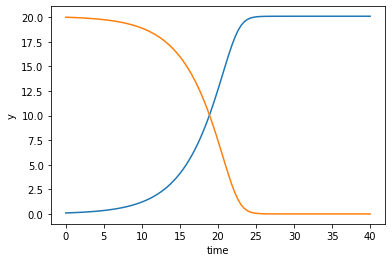

In [61]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# function that returns dy/dt
def model(var,t,params):
    x,g   = var
    um,k,qp = params
    
    u=um*g/(k+g)
    
    deriv = [0,0]
    deriv[0] = u*x     # dx/dt
    deriv[1] = -qp*u*x # dg/dt
    return deriv

# initial condition
var0 = [0.1,20] # x,g

# time points
t = np.linspace(0,40,100)

# solve ODE
params=[0.3,4,1] #um,k,qp
y = odeint(model,var0,t,args=(params,))

# plot results
plt.plot(t,y[:,0]) # t,X
plt.plot(t,y[:,1]) # t,G
plt.xlabel('time')
plt.ylabel('y')
plt.show()

Ejercicios
=====

1. Agregar ruidos estocastico a los datos simulados de $X$ y $G$. Para el ruido considera una distribución normal con valor medio 0, y desviación estandar 0.5 (recordatorio: ```np.random.normal(mean,sd,Npoints)```).
2. Construye una herramienta para estimar los valores de $\mu$, $K$, y $q_G$ que mejor describen los datos simulatos (y con ruido estocastico) de $X$ y $G$.

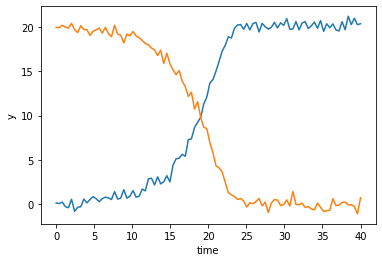

In [62]:
# Ejercicio 1

x=y[:,0]+np.random.normal(0,0.5,len(y))
g=y[:,1]+np.random.normal(0,0.5,len(y))

plt.plot(t,x) # t,X
plt.plot(t,g) # t,G
plt.xlabel('time')
plt.ylabel('y')
plt.show()

In [52]:
len(y)

100